In [1]:
from scipy import optimize, signal
import torch 
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import operator

In [9]:
torch.atleast_1d(torch.tensor(1.0))

tensor([1.])

In [6]:
fs = 8000
nyq = 0.5 * fs
pass_zero = False
cutt = 500
cutoff = torch.atleast_1d(torch.tensor(cutt)) / float(nyq)
pass_nyquist = torch.bitwise_xor(torch.bitwise_and(cutoff.size(0), torch.tensor(1)).bool(), pass_zero)

In [58]:
cutoff

tensor([0.1250])

In [69]:
torch.tensor([0.0] * pass_zero)

tensor([])

In [74]:
cutoff3 = torch.hstack((torch.tensor([0.0] * pass_zero), cutoff, torch.tensor([1.0] * pass_nyquist)))
cutoff3

tensor([0.1250, 1.0000])

In [66]:
[1.0] *False

[]

In [59]:
cutoff2 = np.atleast_1d(cutt) / float(nyq)
pass_nyquist2 = (cutoff2.size & 1) ^ pass_zero

In [75]:
np.hstack(([0.0] * pass_zero, cutoff2, [1.0] * pass_nyquist2))

array([0.125, 1.   ])

In [34]:
cutoff = torch.atleast_1d(torch.tensor(1.))
torch.bitwise_xor(torch.logical_and(torch.tensor(cutoff.size(0)), torch.tensor(1)).bool(), False)

tensor(True)

In [51]:
l1 = torch.randint(4,8,(1,)).float()
l2 = torch.randint(4,8,(1,)).float()
l3 = torch.randint(4,8,(1,)).float()

In [53]:
torch.cat((l1,l2,l3))

tensor([6., 6., 7.])

In [25]:
torch.fmod(torch.tensor(7), torch.tensor(2))

tensor(1)

In [27]:
torch.logical_and(torch.tensor(True), torch.tensor(1.0))

tensor(True)

In [30]:
torch.tensor(1/8)

tensor(0.1250)

In [37]:
torch.cat((torch.tensor([1/8]), torch.tensor(0.175)), dim=0)[1].item()

RuntimeError: zero-dimensional tensor (at position 1) cannot be concatenated

In [47]:
True and 1

1

In [49]:
torch.randint(4,8,(1,)).float().size()

torch.Size([1])

In [46]:
torch.logical_and(torch.tensor(False), torch.tensor(1))

tensor(False)

In [39]:
[1/8, torch.tensor(0.175)]

[0.125, tensor(0.1750)]

In [3]:
from scipy.special import sinc
def _len_guards(M):
    """Handle small or incorrect window lengths"""
    if int(M) != M or M < 0:
        raise ValueError('Window length M must be a non-negative integer')
    return M <= 1


def _extend(M, sym):
    """Extend window by 1 sample if needed for DFT-even symmetry"""
    if not sym:
        return M + 1, True
    else:
        return M, False


def _truncate(w, needed):
    """Truncate window by 1 sample if needed for DFT-even symmetry"""
    if needed:
        return w[:-1]
    else:
        return w

def general_cosine(M, a, sym=True):
    if _len_guards(M):
        return np.ones(M)
    M, needs_trunc = _extend(M, sym)

    fac = np.linspace(-np.pi, np.pi, M)
    w = np.zeros(M)
    for k in range(len(a)):
        w += a[k] * np.cos(k * fac)

    return _truncate(w, needs_trunc)

def general_hamming(M, alpha, sym=True):
    return general_cosine(M, [alpha, 1. - alpha], sym)

def hamming(M, sym=True):
    return general_hamming(M, 0.54, sym)


_win_equiv_raw = {
    # ('barthann', 'brthan', 'bth'): (barthann, False),
    # ('bartlett', 'bart', 'brt'): (bartlett, False),
    # ('blackman', 'black', 'blk'): (blackman, False),
    # ('blackmanharris', 'blackharr', 'bkh'): (blackmanharris, False),
    # ('bohman', 'bman', 'bmn'): (bohman, False),
    # ('boxcar', 'box', 'ones',
    #     'rect', 'rectangular'): (boxcar, False),
    # ('chebwin', 'cheb'): (chebwin, True),
    # ('cosine', 'halfcosine'): (cosine, False),
    # ('dpss',): (dpss, True),
    # ('exponential', 'poisson'): (exponential, False),
    # ('flattop', 'flat', 'flt'): (flattop, False),
    # ('gaussian', 'gauss', 'gss'): (gaussian, True),
    # ('general cosine', 'general_cosine'): (general_cosine, True),
    # ('general gaussian', 'general_gaussian',
    #     'general gauss', 'general_gauss', 'ggs'): (general_gaussian, True),
    # ('general hamming', 'general_hamming'): (general_hamming, True),
    ('hamming', 'hamm', 'ham'): (hamming, False),
    # ('hann', 'han'): (hann, False),
    # ('kaiser', 'ksr'): (kaiser, True),
    # ('kaiser bessel derived', 'kbd'): (kaiser_bessel_derived, True),
    # ('lanczos', 'sinc'): (lanczos, False),
    # ('nuttall', 'nutl', 'nut'): (nuttall, False),
    # ('parzen', 'parz', 'par'): (parzen, False),
    # ('taylor', 'taylorwin'): (taylor, False),
    # ('triangle', 'triang', 'tri'): (triang, False),
    # ('tukey', 'tuk'): (tukey, False),
}

# Fill dict with all valid window name strings
_win_equiv = {}
for k, v in _win_equiv_raw.items():
    for key in k:
        _win_equiv[key] = v[0]

# Keep track of which windows need additional parameters
_needs_param = set()
for k, v in _win_equiv_raw.items():
    if v[1]:
        _needs_param.update(k)


def _get_fs(fs, nyq):
    """
    Utility for replacing the argument 'nyq' (with default 1) with 'fs'.
    """
    if nyq is None and fs is None:
        fs = 2
    elif nyq is not None:
        if fs is not None:
            raise ValueError("Values cannot be given for both 'nyq' and 'fs'.")
        msg = ("Keyword argument 'nyq' is deprecated in favour of 'fs' and "
               "will be removed in SciPy 1.12.0.")
        #warnings.warn(msg, DeprecationWarning, stacklevel=3)
        fs = 2*nyq
    return fs


def get_window(window, Nx, fftbins=True):
    
    sym = not fftbins
    try:
        beta = float(window)
    except (TypeError, ValueError) as e:
        args = ()
        if isinstance(window, tuple):
            winstr = window[0]
            if len(window) > 1:
                args = window[1:]
        elif isinstance(window, str):
            if window in _needs_param:
                raise ValueError("The '" + window + "' window needs one or "
                                 "more parameters -- pass a tuple.") from e
            else:
                winstr = window
        else:
            raise ValueError("%s as window type is not supported." %
                             str(type(window))) from e

        try:
            winfunc = _win_equiv[winstr]
        except KeyError as e:
            raise ValueError("Unknown window type.") from e

        #params = (Nx,) + args + (None,)
        params = (Nx,) + args
        # if winfunc is dpss:
        #     params = (Nx,) + args + (None,)   
        # else:
        #     params = (Nx,) + args
    # else:
    #     winfunc = kaiser
    #     params = (Nx, beta)

    return winfunc(*params, sym=sym)

def firwin_scipy(numtaps, cutoff, width=None, window='hamming', pass_zero=True,
           scale=True, nyq=None, fs=None):
    

    nyq = 0.5 * _get_fs(fs, nyq)

    cutoff = np.atleast_1d(cutoff) / float(nyq)

    # Check for invalid input.
    if cutoff.ndim > 1:
        raise ValueError("The cutoff argument must be at most "
                         "one-dimensional.")
    if cutoff.size == 0:
        raise ValueError("At least one cutoff frequency must be given.")
    if cutoff.min() <= 0 or cutoff.max() >= 1:
        raise ValueError("Invalid cutoff frequency: frequencies must be "
                         "greater than 0 and less than fs/2.")
    if np.any(np.diff(cutoff) <= 0):
        raise ValueError("Invalid cutoff frequencies: the frequencies "
                         "must be strictly increasing.")

    # if width is not None:
    #     # A width was given.  Find the beta parameter of the Kaiser window
    #     # and set `window`.  This overrides the value of `window` passed in.
    #     atten = kaiser_atten(numtaps, float(width) / nyq)
    #     beta = kaiser_beta(atten)
    #     window = ('kaiser', beta)

    if isinstance(pass_zero, str):
        if pass_zero in ('bandstop', 'lowpass'):
            if pass_zero == 'lowpass':
                if cutoff.size != 1:
                    raise ValueError('cutoff must have one element if '
                                     'pass_zero=="lowpass", got %s'
                                     % (cutoff.shape,))
            elif cutoff.size <= 1:
                raise ValueError('cutoff must have at least two elements if '
                                 'pass_zero=="bandstop", got %s'
                                 % (cutoff.shape,))
            pass_zero = True
        elif pass_zero in ('bandpass', 'highpass'):
            if pass_zero == 'highpass':
                if cutoff.size != 1:
                    raise ValueError('cutoff must have one element if '
                                     'pass_zero=="highpass", got %s'
                                     % (cutoff.shape,))
            elif cutoff.size <= 1:
                raise ValueError('cutoff must have at least two elements if '
                                 'pass_zero=="bandpass", got %s'
                                 % (cutoff.shape,))
            pass_zero = False
        else:
            raise ValueError('pass_zero must be True, False, "bandpass", '
                             '"lowpass", "highpass", or "bandstop", got '
                             '{}'.format(pass_zero))
    pass_zero = bool(operator.index(pass_zero))  # ensure bool-like

    pass_nyquist = bool(cutoff.size & 1) ^ pass_zero
    if pass_nyquist and numtaps % 2 == 0:
        raise ValueError("A filter with an even number of coefficients must "
                         "have zero response at the Nyquist frequency.")

    # Insert 0 and/or 1 at the ends of cutoff so that the length of cutoff
    # is even, and each pair in cutoff corresponds to passband.
    cutoff = np.hstack(([0.0] * pass_zero, cutoff, [1.0] * pass_nyquist))

    # `bands` is a 2-D array; each row gives the left and right edges of
    # a passband.
    bands = cutoff.reshape(-1, 2)

    # Build up the coefficients.
    alpha = 0.5 * (numtaps - 1)
    m = np.arange(0, numtaps) - alpha
    h = 0
    for left, right in bands:
        h += right * sinc(right * m)
        h -= left * sinc(left * m)

    # Get and apply the window function.
    #from .windows import get_window
    win = get_window(window, numtaps, fftbins=False)
    h *= win

    # Now handle scaling if desired.
    if scale:
        # Get the first passband.
        left, right = bands[0]
        if left == 0:
            scale_frequency = 0.0
        elif right == 1:
            scale_frequency = 1.0
        else:
            scale_frequency = 0.5 * (left + right)
        c = np.cos(np.pi * m * scale_frequency)
        s = np.sum(h * c)
        h /= s

    return h

In [25]:
def _get_fs(fs, nyq):
    """
    Utility for replacing the argument 'nyq' (with default 1) with 'fs'.
    """
    if nyq is None and fs is None:
        fs = 2
    elif nyq is not None:
        # if fs is not None:
        #     raise ValueError("Values cannot be given for both 'nyq' and 'fs'.")
        # msg = ("Keyword argument 'nyq' is deprecated in favour of 'fs' and "
        #        "will be removed in SciPy 1.12.0.")
        # warnings.warn(msg, DeprecationWarning, stacklevel=3)
        fs = 2*nyq
    return fs


def firwin_torch(numtaps, cutoff, width=None, window='hamming', pass_zero=True,
           scale=True, nyq=None, fs=None):
    

    nyq = 0.5 * _get_fs(fs, nyq)

    cutoff = torch.atleast_1d(torch.tensor(cutoff)) / float(nyq)

    # # Check for invalid input.
    # if cutoff.ndim > 1:
    #     raise ValueError("The cutoff argument must be at most "
    #                      "one-dimensional.")
    # if cutoff.size == 0:
    #     raise ValueError("At least one cutoff frequency must be given.")
    # if cutoff.min() <= 0 or cutoff.max() >= 1:
    #     raise ValueError("Invalid cutoff frequency: frequencies must be "
    #                      "greater than 0 and less than fs/2.")
    # if np.any(np.diff(cutoff) <= 0):
    #     raise ValueError("Invalid cutoff frequencies: the frequencies "
    #                      "must be strictly increasing.")

    # if width is not None:
    #     # A width was given.  Find the beta parameter of the Kaiser window
    #     # and set `window`.  This overrides the value of `window` passed in.
    #     atten = kaiser_atten(numtaps, float(width) / nyq)
    #     beta = kaiser_beta(atten)
    #     window = ('kaiser', beta)

    if isinstance(pass_zero, str):
        if pass_zero in ('bandstop', 'lowpass'):
            if pass_zero == 'lowpass':
                if cutoff.size(0) != 1:
                    raise ValueError('cutoff must have one element if '
                                     'pass_zero=="lowpass", got %s'
                                     % (cutoff.size(),))
            elif cutoff.size(0) <= 1:
                raise ValueError('cutoff must have at least two elements if '
                                 'pass_zero=="bandstop", got %s'
                                 % (cutoff.size(),))
            pass_zero = True
        elif pass_zero in ('bandpass', 'highpass'):
            if pass_zero == 'highpass':
                if cutoff.size(0) != 1:
                    raise ValueError('cutoff must have one element if '
                                     'pass_zero=="highpass", got %s'
                                     % (cutoff.size(),))
            elif cutoff.size(0) <= 1:
                raise ValueError('cutoff must have at least two elements if '
                                 'pass_zero=="bandpass", got %s'
                                 % (cutoff.size(),))
            pass_zero = False
        else:
            raise ValueError('pass_zero must be True, False, "bandpass", '
                             '"lowpass", "highpass", or "bandstop", got '
                             '{}'.format(pass_zero))

    # pass_zero = bool(operator.index(pass_zero))  # ensure bool-like

    # pass_nyquist = bool(cutoff.size & 1) ^ pass_zero
    pass_nyquist = torch.bitwise_xor(torch.bitwise_and(cutoff.size(0), torch.tensor(1)).bool(), pass_zero)
    #if pass_nyquist and numtaps % 2 == 0:
    if torch.logical_and(pass_nyquist, torch.fmod(torch.tensor(numtaps), 2)):
        raise ValueError("A filter with an even number of coefficients must "
                         "have zero response at the Nyquist frequency.")

    # Insert 0 and/or 1 at the ends of cutoff so that the length of cutoff
    # is even, and each pair in cutoff corresponds to passband.
    #cutoff = np.hstack(([0.0] * pass_zero, cutoff, [1.0] * pass_nyquist))
    cutoff = torch.hstack((torch.tensor([0.0] * pass_zero), cutoff, torch.tensor([1.0] * pass_nyquist)))

    # `bands` is a 2-D array; each row gives the left and right edges of
    # a passband.
    bands = cutoff.reshape(-1, 2)

    # Build up the coefficients.
    alpha = 0.5 * (numtaps - 1)
    m = torch.arange(0, numtaps) - alpha
    h = 0
    for left, right in bands:
        h += right * torch.sinc(right * m)
        h -= left * torch.sinc(left * m)

    # Get and apply the window function.
    # from .windows import get_window
    # win = get_window(window, numtaps, fftbins=False)
    if window == 'hamming':
        win = torch.hamming_window(numtaps)
    else:
        raise ValueError("Only hamming window allowed")
    h = h * win
    #
    
    # Now handle scaling if desired.
    if scale:
        # Get the first passband.
        left, right = bands[0]
        if left == 0:
            scale_frequency = 0.0
        elif right == 1:
            scale_frequency = 1.0
        else:
            scale_frequency = 0.5 * (left + right)
        c = torch.cos(torch.pi * m * scale_frequency)
        s = torch.sum(h * c)
        h /= s

    return h


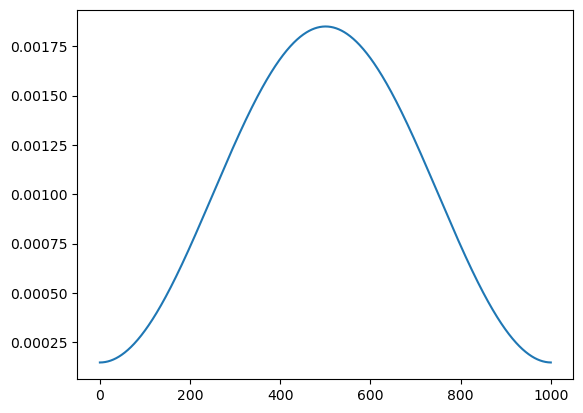

In [26]:
fl = 30
fh = 800
w = [fl / (fs / 2), fh / (fs / 2)]
pp = firwin_torch(1000+1 , w, pass_zero='bandpass', fs=fs)
plt.plot(pp)

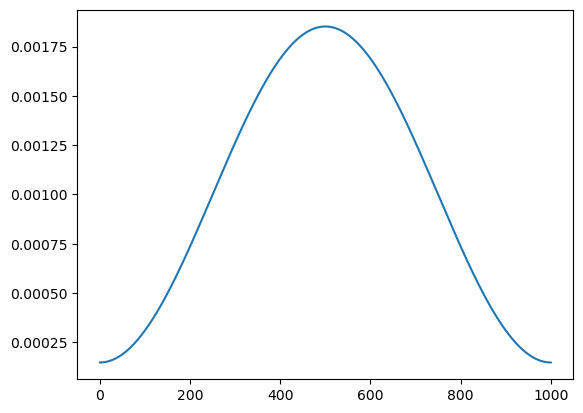

In [20]:
fl = 30
fh = 800
w = [fl / (fs / 2), fh / (fs / 2)]
ps = signal.firwin(1000 + 1, w, pass_zero='bandpass', fs=fs)
plt.plot(ps)

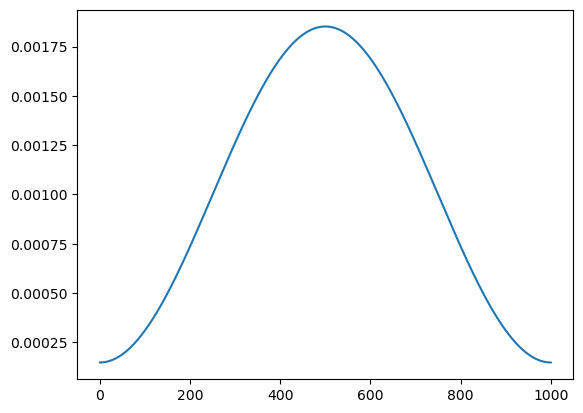

In [22]:
hp = firwin_scipy(1000 + 1, w , pass_zero='bandpass', fs=fs)
plt.plot(hp)

In [11]:
torch.hamming_window()

tensor([0.0800, 0.2147, 0.5400, 0.8653, 1.0000, 0.8653, 0.5400, 0.2147])

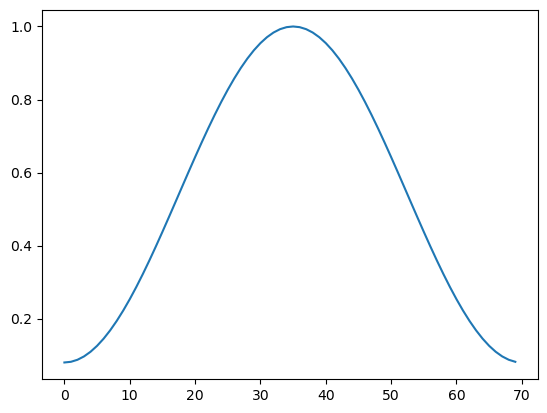

In [98]:
plt.plot(torch.hamming_window(70))

In [13]:
hamming(8)

array([0.08      , 0.25319469, 0.64235963, 0.95444568, 0.95444568,
       0.64235963, 0.25319469, 0.08      ])

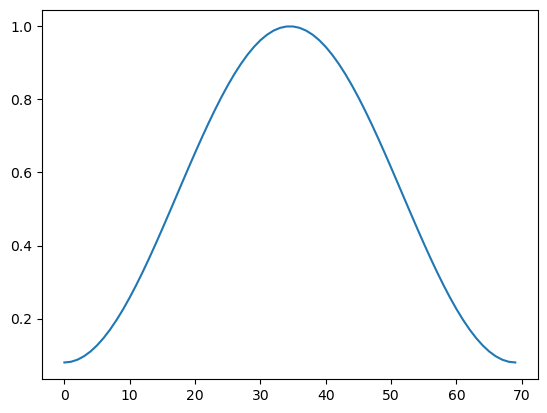

In [100]:
plt.plot(hamming(70))

In [2]:
signal.get_window('hamming', 7)

array([0.08      , 0.25319469, 0.64235963, 0.95444568, 0.95444568,
       0.64235963, 0.25319469])